**TODO** @Kyubin

**Content / Style:**
- Improve the explanations. They were written in a hurry and only with little love. If you have questions, that's a bad sign. The notebook should be completely self explenatory by just following the comments.
- Refine the commentary with better analogies and examples. Utilize the 'mother trick': imagine how you would explain the complicated topics here to your mother. Note that this is probably not going to work, if your mother is a leading machine learning expert.
- Maybe add references where appropriate, e.g. to algorithms or papers.
- Add some cool pictures, for example for visualizing how word vectors work or like that. These should not be too technical or complicated.
- Think of better examples for showing the similarities in the vectors between sentences. I don't really like the current one.

**Data / Results:**
- More tweets!
- Maybe choose or try a better topic than the Apple credit card. But keep in mind, that we are most probably going to change the topic shortly before the actual workshop anyway so it's up to date.
- Try different clustering algorithm. Refer to https://scikit-learn.org/stable/modules/clustering.html
- Try other parameters for the t-SNE algorithm. Especially perplexity and number of iterations are important.

In [5]:
cd ..

/mnt/c/Users/admin/OneDrive - Imperial College London/AppliedAI


!pip -V

In [2]:
!pip install toolz

     |████████████████████████████████| 51kB 1.5MB/s eta 0:00:01
  Created wheel for toolz: filename=toolz-0.10.0-cp37-none-any.whl size=55577 sha256=55a3612ec7fde813b5ea1eca94dd9713acc735483ed9a39cf8e466cb39a3d03e
  Stored in directory: /home/kyubin/.cache/pip/wheels/e1/8b/65/3294e5b727440250bda09e8c0153b7ba19d328f661605cb151
Successfully built toolz


In [3]:
# The following lines are important for the code to work.
# Better don't touch them.

import os
import re
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow_hub as hub
import tensorflow as tf
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn.metrics.pairwise import cosine_similarity
from toolz.curried import curry, pipe, filter, map, complement
from matplotlib import pyplot as plt
from unidecode import unidecode
from MulticoreTSNE import MulticoreTSNE

# Data Preprocessing

**Read raw tweets from a CSV file.**

In [41]:
data_root = '/mnt/c/Users/admin/OneDrive - Imperial College London/AppliedAI/NLP'
data_file = os.path.join(data_root, 'tweets20-28_1.csv')

tweets_raw = pd.read_csv(data_file)
tweets = tweets_raw['text'].values
tweets = list(set(tweets))

print(f'{len(tweets)} tweets loaded')

18568 tweets loaded


At the current state, many of the tweets contain spam or special characters that might disturb the analysis later on.

Therefore, the next step is to get rid of clutter by **filtering and cleaning the data.**

In [9]:
from toolz.curried import curry

In [42]:
contains_url = lambda s: 'http' in s

re_special = re.compile(r'[^a-zA-Z\. ]')
re_hashtag = re.compile(r'#\S+')
re_spaces = re.compile(r'\s+')
re_pic = re.compile(r'pic.twitter.com/\S+')

sub_special = curry(re_special.sub)
sub_hashtag = curry(re_hashtag.sub)
sub_spaces = curry(re_spaces.sub)
sub_pic_urls = curry(re_pic.sub)  # removes urls referencing pictures

# @Kyubin the beauty of functional programming
processed = pipe(tweets,
                 filter(complement(contains_url)),  # filter tweets containing urls, indicating spam
                 map(unidecode),  # turn unidecode characters into ascii
                 map(sub_pic_urls('')),  # remove urls referencing pictures
                 # map(sub_hashtag('')),
                 #sub_special('')),  # remove special characters
                 map(sub_spaces(' ')),  # remove multi spaces and tab stops
                 map(str.strip),  # strip
                 filter(bool),  # filter out empty samples
                 set,
                 list)

filter_ratio = len(processed) / len(tweets)

print(f'{filter_ratio * 100:.2f}% ({len(processed)} samples) tweets remaining after filtering and cleaning')

53.69% (9970 samples) tweets remaining after filtering and cleaning


<div class="alert alert-info">
    <h3>Question</h3>
    <p>The processing pipeline (the code between line 14 and 22) contains a currently disabled filter for hashtags.</p>
    <p>Can you figure out how to enable it?</p>
    <p>How do the results change?</p>
    <p>Is it better to enable or disable it?</p>
</div>

At this point, we have a few thousand samples of cleaned tweets ready for further analysis.

**Let us take a look into some of them.**

In [43]:
for tweet in np.random.choice(processed, size=10):
    print(f'- {tweet}')

- Simple wallpaper for iPhone #iphone #iPhoneX #iPhoneXS #iPhoneXR #iPhoneXSMAX #Wallpapers #AppleCard #AppleEvent #iOS13
- Apple Card fire?
- I can't think of any other reason
- Haven't used it yet. It's in my wallet on my phone. But I'm really waiting on that actually card. Gonna be interesting to buy things online with no actual credit card number
- My apple card is gonna look black after the first week
- My Apple Card arrives in 6 days
- You rejected me lol
- I'm working on jailbreak tweak that makes Apple Card matte black
- So can I stop paying off my Barclays card?
- @AppleCard Does Apple Card report to the credit bureaus? Will limit increase over time of good payment? Can you request limit increase? If so, when?


# Compute Tweet Embeddings

As computers are working with bits and bytes and not words, it's difficult to let them understand human language.

There are different methods how to bridge the language barrier but we will go for one, where we basically transform text into a bunch of numbers but which actually preserver the semantics of the content.

This method of text transformation is called _sentence to vector_ as we have a text as an input and a vector of fixed size as output. We will use an algorithm for this, that already has been previously trained on millions of documents. By empowering this _pretrained_ model, we can achieve good results with only little data, computational time and hence can reduce the costs of time and money.

With these semantical vectors, it is going to be much easier, to cluster the tweets by their meaning and sentiment.

In [45]:
# Downlodas the pre-trained model from the interent (~1 GB). This may take up to a few minutes.
embed = hub.Module('https://tfhub.dev/google/universal-sentence-encoder/2')

sess = tf.InteractiveSession()
sess.run([tf.global_variables_initializer(), tf.tables_initializer()]);  # Initialize model

After the model has been downloaded and initialized, we can start computing our semantic vectors from the tweets.

But before we start, **let us get an intuition of how it works.**

Consider the following sentences that might be grouped into to semantical similiar topics A and B:

**A:**
- _The BMW I bought recently is really nice._
- _I love the new car I got yesterday._

**B:**
- _The food was already cold when served and way too expensive._
- _We had to wait for a long time and the menu wans't really good in the end._

Obviously all the sentences have a different wording and meaning but still the similarities within the groups are visible.

This observation should be also covered by our sentence-encoding model. Concretely, the resulting vectors of two semantically similar sentences should also be close to each other. Let us test this by computing the cosine similarity between them.

In [47]:
sents = [
    # A
    'The BMW I bought recently is really nice.',
    'I love the new car I got yesterday.',

    # B
    'The food was already cold when served and way too expensive.',
    'We had to wait a long time for a waiter and there were little cheap options.'
]

sent_vecs = sess.run(
    embed(sents)
)

similarities = cosine_similarity(sent_vecs)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


After computing the similiarity between the vectors, we can visualize them in a confusion matrix for comparison.

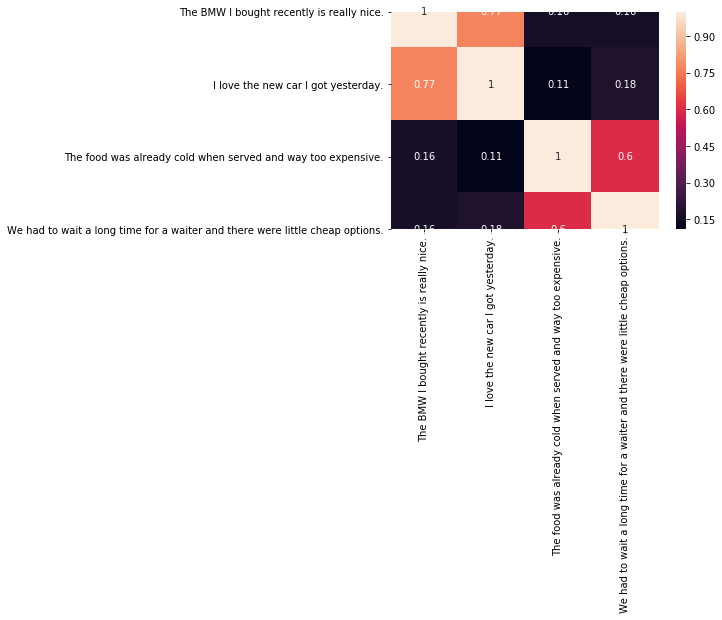

In [48]:
sn.heatmap(pd.DataFrame(similarities, index=sents, columns=sents), annot=True)
plt.show()

Notice how the first two sentence have a high similiarity score, close to zero while maintaining a low one for the others. Same applies for the other group, namely the last two sentences compared to first ones.

<div class="alert alert-info">
    <h3>Question</h3>
    <p>How do the scores behave if you change the meaning of a sentence?</p>
    <p>Try for example, to turn the negative restaurant review into a positive one</p>
</div>

After we have some intuition for this method, the next step is to apply it to our tweets by **computing a semantic vector for all of them.**

In [49]:
tweet_vecs = sess.run(
    embed(processed)
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


At this point, we can have a try to visualize the actual vectors corresponding to the tweets.

Although it's hard for a human, at least for most, to conclude the meaning of sentences from pure numbers it's nonetheless interesting to see, what our algorithm has produced. The following code snipped plots the vectors for the first 200 hundred samples our dataset.

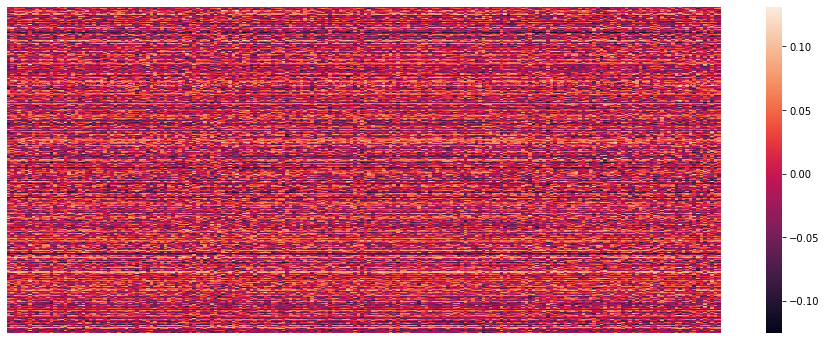

In [50]:
plt.figure(figsize=(16, 6))
sn.heatmap(tweet_vecs[:200, :].T, xticklabels=False, yticklabels=False)
plt.show()

<div class="alert alert-info">
    <h3>Question</h3>
    <p>Does this diagram look familiar?</p>
    <p><b>Hint:</b> think of light or sound spectrums. What analogy could you think about in this context?</p>
</div>

# Clustering

Now it's time to get our hands on the clustering.

The idea is to let an algorithm decide which of the vectors look similiar.

In [51]:
n_clusters = 6

model = KMeans(n_clusters, max_iter=1000)
model.fit(tweet_vecs);

After having trained (_fitted_) the algorithm on our data, we can get our prediction which tweet belongs to which class.

In [52]:
classes = np.argmax(model.transform(tweet_vecs), axis=-1)

In [53]:
clusters = []

for cluster_i in range(n_clusters):
    clusters.append([processed[i] for i, cls in enumerate(classes) if cluster_i == cls])

In [54]:
tweets_df = pd.DataFrame({'text': processed, 'class': classes})
tweets_df.head(n=18)  # show the 'head' of the data

text  class
0   Just don't store your apple card with the ribe...      0
1   Need to make adding your spouse to the card an...      2
2   I am afraid to use my Apple card for the fear ...      4
3   But we all know that @Apple is in the business...      0
4                         should I get an Apple Card?      0
5   @AppleCard is there a delay in shipping physic...      0
6   Correct and frankly it's not that I care I jus...      3
7   i'm about to apply for that apple card so i ca...      0
8   I want my #AppleCard to always stay white in t...      0
9   Apple Card is a First... First card I've ever ...      0
10                                got apple card lmao      0
11  never showing nobody my apple card cuz niggas ...      0
12         18%???? With Excellent credit??? No thanks      2
13  Can't use Apple Watch with tattoos, can't use ...      4
14  Can't wait to get my Apple Card RUN THAT BITCH UP      4
15  Sweet! And we get to earn 3% on top of that us...      0
16                                       I want one??      3
17  And prior to get the card you have to report y...      1

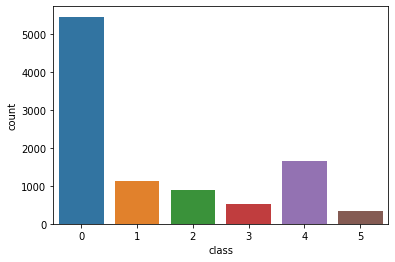

In [55]:
sn.countplot(x="class", data=tweets_df)
plt.show()

In [56]:
for i, cluster in enumerate(clusters):
    print(f'Samples for cluster {i + 1}')
    
    if not cluster:
        print('+ no samples +\n')
        continue
        
    samples = np.random.choice(cluster, size=3)
    for sample in samples:
        print(f'- {sample}')
    print()

Samples for cluster 1
- Nothing personal but if you get an Apple Card, I hate you.
- You say that Apple Card is "easier to keep tabs on" but it isn't. There is no way for a couple or family to sync up spending, and there isn't even a way to download data into a tool like Quicken. I love most Apple things, but this is missing a core feature! cc @daringfireball
- It takes 1-2 business days just like every other credit card, it's a credit card not a debit card

Samples for cluster 2
- I ended up calling Trans Union who told me my phone number needed to be added to their information. Once I did that I applied successfully for the AppleCard. Apple and GS were of no help when I talked to them.
- Isn't that insane that a leather wallet and jeans are a no go? they need to reformulate the coat of the card
- Shou Dao Apple CardLiao ,Xia Ge Wen Ti Shi Ru He Zhuang Zai Qian Bao Li Cai Neng Bu Tun Se ..

Samples for cluster 3
- Process Complete: @AppleCard
- I bet that is the real reason for this c

<div class="alert alert-info">
    <h3>Question</h3>
    <p>How does the clustering algorithm behave, if you increase or decrease the number of clusters? Try to adjust the <i>n_clusters</i> variable for this.</p>
</div>

# Exploration

In [67]:
# t-SNE produces too bad results by now. Fix that!


tsne = MulticoreTSNE(n_components=3,
                     n_iter=5000,
                     perplexity=30,
                     n_jobs=5,
                     verbose=True)

# May take up to a few minutes
tweets_vecs_3d = tsne.fit_transform(tweet_vecs)


In [62]:
pca = PCA(3)
pca.fit(tweet_vecs)

tweets_vecs_3d = pca.transform(tweet_vecs)

In [68]:
tweets_df['x'] = tweets_vecs_3d[:, 0]
tweets_df['y'] = tweets_vecs_3d[:, 1]
tweets_df['z'] = tweets_vecs_3d[:, 2]

In [69]:
fig = px.scatter_3d(tweets_df, x='x', y='y', z='z', color='class', hover_name='text')
fig.update_traces(marker=dict(size=3, opacity=0.7))
fig.show()

<div class="alert alert-info">
    <h3>Task</h3>
    <p>Try to figure out, what abstract topic each cluster corresponds to.</p>
    <p>Keep in mind, that due to the nature of the data and the algorithms, it's hardly possible to assign a clear topic to each single tweet.</p>
    <p>Instead, the results can give an intuition about the general direction a discussion follows.</p>
</div>